In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=a2e47efbf1ea64082b6f2ec774973716439157cba5c9c547b6297985abc456e6
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
!gdown 1ZjBn9K3gwSeiq1NqgL-Vsrr0Y33nmlai

Downloading...
From (original): https://drive.google.com/uc?id=1ZjBn9K3gwSeiq1NqgL-Vsrr0Y33nmlai
From (redirected): https://drive.google.com/uc?id=1ZjBn9K3gwSeiq1NqgL-Vsrr0Y33nmlai&confirm=t&uuid=55466e1f-6f1d-4e1b-b7b2-8b7da897b3b6
To: /content/archive (6).zip
100% 205M/205M [00:00<00:00, 247MB/s]


In [3]:
!unzip '/content/archive (6).zip'

Archive:  /content/archive (6).zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing PySpark libraries
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F

In [5]:
# Create a Spark session
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

In [6]:
# Convert Pandas DataFrames to Spark DataFrames
genome_scores_spark = spark.read.csv('/content/genome_scores.csv', header=True, inferSchema=True)
genome_tags_spark = spark.read.csv('/content/genome_tags.csv', header=True, inferSchema=True)
link_spark = spark.read.csv('/content/link.csv', header=True, inferSchema=True)
movie_spark = spark.read.csv('/content/movie.csv', header=True, inferSchema=True)
rating_spark = spark.read.csv('/content/rating.csv', header=True, inferSchema=True)
tag_spark = spark.read.csv('/content/tag.csv', header=True, inferSchema=True)

In [ ]:
rating_distribution = rating_spark.groupBy("rating").count().orderBy("rating")
rating_distribution.show()

+------+-------+
|rating|  count|
+------+-------+
|   0.5| 239125|
|   1.0| 680732|
|   1.5| 279252|
|   2.0|1430997|
|   2.5| 883398|
|   3.0|4291193|
|   3.5|2200156|
|   4.0|5561926|
|   4.5|1534824|
|   5.0|2898660|
+------+-------+



<ipython-input-18-56af2e919cfd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="genres", data=genres_distribution.toPandas(), palette="viridis")


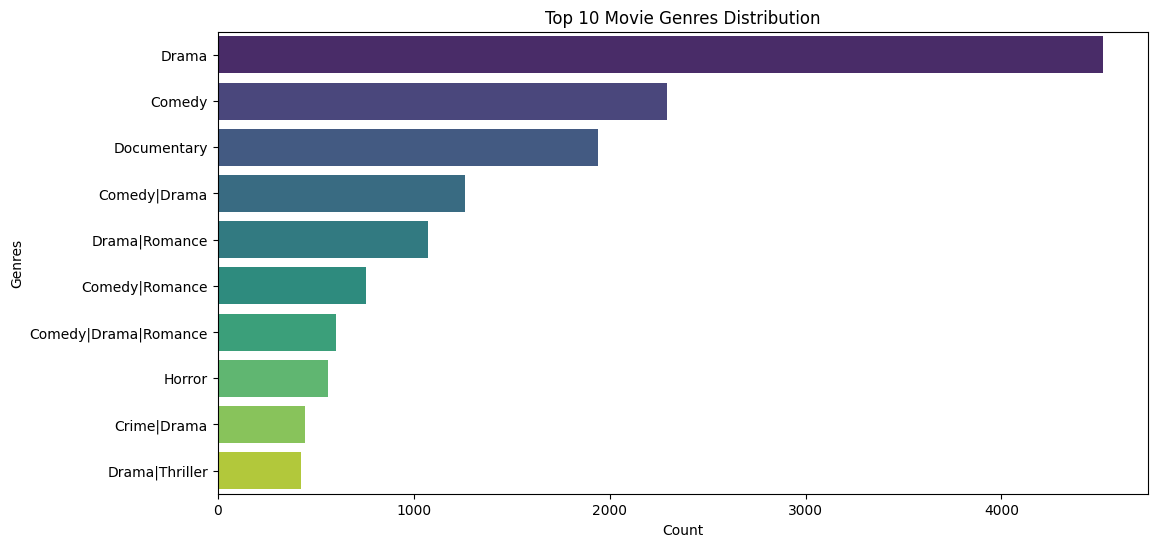

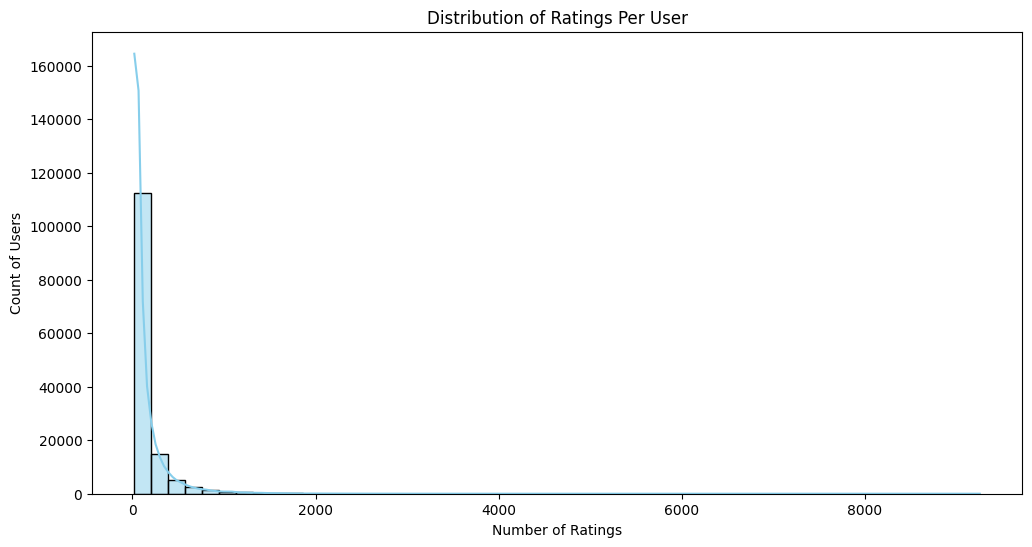

In [ ]:
# Visualizing movie genres distribution
genres_distribution = movie_spark.select("genres").groupBy("genres").count().orderBy("count", ascending=False).limit(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="genres", data=genres_distribution.toPandas(), palette="viridis")
plt.title('Top 10 Movie Genres Distribution')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

# Exploring the distribution of the number of ratings per user
ratings_per_user = rating_spark.groupBy("userId").count().orderBy("count", ascending=False)

plt.figure(figsize=(12, 6))
sns.histplot(ratings_per_user.toPandas()["count"], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Ratings Per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()


In [7]:
# ALS requires numerical user and item ids, so let's create a mapping
user_mapping = rating_spark.select("userId").distinct().withColumn("user_idx", F.monotonically_increasing_id())
item_mapping = rating_spark.select("movieId").distinct().withColumn("item_idx", F.monotonically_increasing_id())

# Join mappings with ratings
ratings_mapped = rating_spark.join(user_mapping, on="userId").join(item_mapping, on="movieId")

In [ ]:
# Splitting the data into training and testing sets
(training, test) = ratings_mapped.randomSplit([0.8, 0.2])

# Building the recommendation model using ALS on the training data
als = ALS(maxIter=5, regParam=0.01, userCol="user_idx", itemCol="item_idx", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(training)

# Making predictions on the test set
predictions = model.transform(test)

# Evaluating the model
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = {:.2f}".format(rmse))

# Visualizing actual vs predicted ratings
predictions_df = predictions.select("rating", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="rating", y="prediction", data=predictions_df)
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()